In this notebook, we will build a 3D map of a scene from a small set of images and then localize an image downloaded from the Internet. This demo was contributed by [Philipp Lindenberger](https://github.com/Phil26AT/).

In [10]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook

tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path
import numpy as np

from packages.hloc import (
    extract_features,
    match_features,
    reconstruction,
    visualization,
    pairs_from_exhaustive,
    pairs_from_covisibility,
)
from packages.hloc.visualization import plot_images, read_image
from packages.hloc.utils import viz_3d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup
Here we define some output paths.

In [11]:
images = Path("/home/jkgao/Documents/GitHub/mirg/data/public_inspection_reports/data/images")
outputs = Path("outputs/demo/")
! rm -rf $outputs
sfm_pairs = outputs / "pairs-sfm.txt"
loc_pairs = outputs / "pairs-loc.txt"
sfm_dir = outputs / "sfm"
features = outputs / "features.h5"
matches = outputs / "matches.h5"

feature_conf = extract_features.confs["disk"]
matcher_conf = match_features.confs["disk+lightglue"]

# 3D mapping
First we list the images used for mapping. These are all day-time shots of Sacre Coeur.

2 mapping images


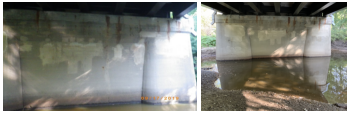

In [12]:
references = [p.relative_to(images).as_posix() for p in (images).iterdir()]
print(len(references), "mapping images")
plot_images([read_image(images / r) for r in references], dpi=25)

Then we extract features and match them across image pairs. Since we deal with few images, we simply match all pairs exhaustively. For larger scenes, we would use image retrieval, as demonstrated in the other notebooks.

In [13]:
extract_features.main(
    feature_conf, images, image_list=references, feature_path=features
)
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2024/09/12 16:39:04 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}


  0%|          | 0/2 [00:00<?, ?it/s]

[2024/09/12 16:39:04 hloc INFO] Finished exporting features.
[2024/09/12 16:39:04 hloc INFO] Found 1 pairs.
[2024/09/12 16:39:04 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}


  0%|          | 0/1 [00:00<?, ?it/s]

[2024/09/12 16:39:04 hloc INFO] Finished exporting matches.


The we run incremental Structure-From-Motion and display the reconstructed 3D model.

In [14]:
model = reconstruction.main(
    sfm_dir, images, sfm_pairs, features, matches, image_list=references
)
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(
    fig, model, color="rgba(255,0,0,0.5)", name="mapping", points_rgb=True
)
fig.show()

[2024/09/12 16:39:05 hloc INFO] Creating an empty database...


[2024/09/12 16:39:05 hloc INFO] Importing images into the database...
[2024/09/12 16:39:06 hloc INFO] Importing features into the database...


  0%|          | 0/2 [00:00<?, ?it/s]

[2024/09/12 16:39:06 hloc INFO] Importing matches into the database...


  0%|          | 0/1 [00:00<?, ?it/s]

[2024/09/12 16:39:06 hloc INFO] Performing geometric verification of the matches...
I20240912 16:39:06.059315 139762404918848 misc.cc:198] 
Feature matching
I20240912 16:39:06.059713 139762379740736 sift.cc:1457] Creating SIFT CPU feature matcher
I20240912 16:39:06.059754 139767589508672 sift.cc:1457] Creating SIFT CPU feature matcher
I20240912 16:39:06.059810 139767581115968 sift.cc:1457] Creating SIFT CPU feature matcher
I20240912 16:39:06.059821 139762388133440 sift.cc:1457] Creating SIFT CPU feature matcher
I20240912 16:39:06.059833 139764342715968 sift.cc:1457] Creating SIFT CPU feature matcher
I20240912 16:39:06.060003 139764334323264 sift.cc:1457] Creating SIFT CPU feature matcher
I20240912 16:39:06.060033 139763951171136 sift.cc:1457] Creating SIFT CPU feature matcher
I20240912 16:39:06.060037 139764325930560 sift.cc:1457] Creating SIFT CPU feature matcher
I20240912 16:39:06.060106 139763959563840 sift.cc:1457] Creating SIFT CPU feature matcher
I20240912 16:39:06.060111 1397639

We also visualize which keypoints were triangulated into the 3D model.

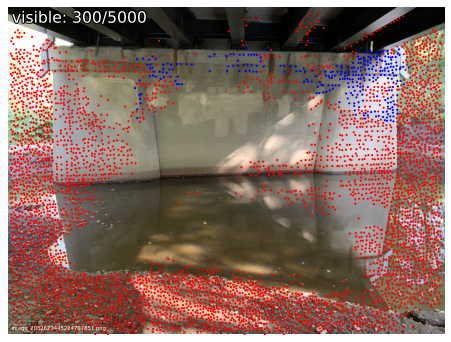

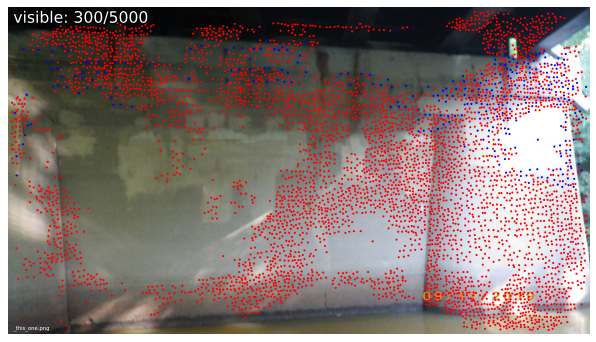

In [15]:
visualization.visualize_sfm_2d(model, images, color_by="visibility", n=2)

# Localization
Now that we have a 3D map of the scene, we can localize any image. To demonstrate this, we download [a night-time image from Wikimedia](https://commons.wikimedia.org/wiki/File:Paris_-_Basilique_du_Sacr%C3%A9_Coeur,_Montmartre_-_panoramio.jpg).

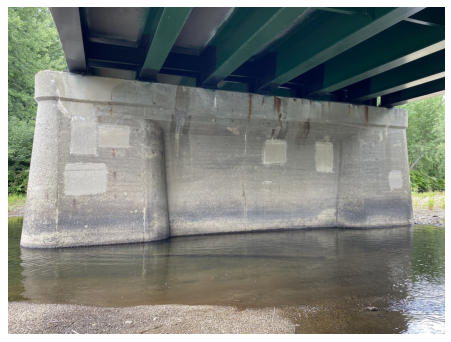

In [17]:
# url = "https://upload.wikimedia.org/wikipedia/commons/5/53/Paris_-_Basilique_du_Sacr%C3%A9_Coeur%2C_Montmartre_-_panoramio.jpg"
# try other queries by uncommenting their url
# url = "https://upload.wikimedia.org/wikipedia/commons/5/59/Basilique_du_Sacr%C3%A9-C%C5%93ur_%285430392880%29.jpg"
# url = "https://upload.wikimedia.org/wikipedia/commons/8/8e/Sacr%C3%A9_C%C5%93ur_at_night%21_%285865355326%29.jpg"
query = "/home/jkgao/Documents/GitHub/mirg/data/public_inspection_reports/data/200030002008022/viewreport.ashx-3/images/concrete_bridge_with_green_railing_over_calm_water.png"
# query = "/home/jkgao/Documents/GitHub/mirg/data/public_inspection_reports/data/200030002008022/viewreport.ashx-3/images/image_899769338094053002.png"
# !mkdir -p $images/query && wget $url -O $images/$query -q
plot_images([read_image(images / query)], dpi=75)

Again, we extract features for the query and match them exhaustively.

In [18]:
extract_features.main(
    feature_conf, images, image_list=[query], feature_path=features, overwrite=True
)
pairs_from_exhaustive.main(loc_pairs, image_list=[query], ref_list=references)
match_features.main(
    matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True
);

[2024/09/12 16:40:34 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}


  0%|          | 0/1 [00:00<?, ?it/s]

[2024/09/12 16:40:34 hloc INFO] Finished exporting features.
[2024/09/12 16:40:34 hloc INFO] Found 2 pairs.
[2024/09/12 16:40:34 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}


  0%|          | 0/2 [00:00<?, ?it/s]

[2024/09/12 16:40:34 hloc INFO] Finished exporting matches.


We read the EXIF data of the query to infer a rough initial estimate of camera parameters like the focal length. Then we estimate the absolute camera pose using PnP+RANSAC and refine the camera parameters.

found 12/19 inlier correspondences.


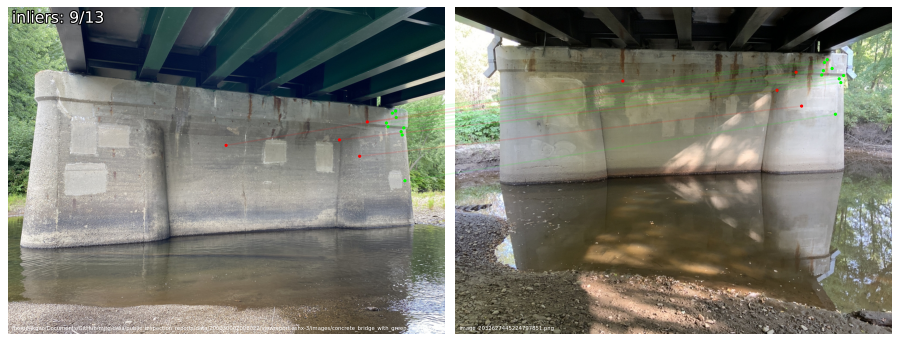

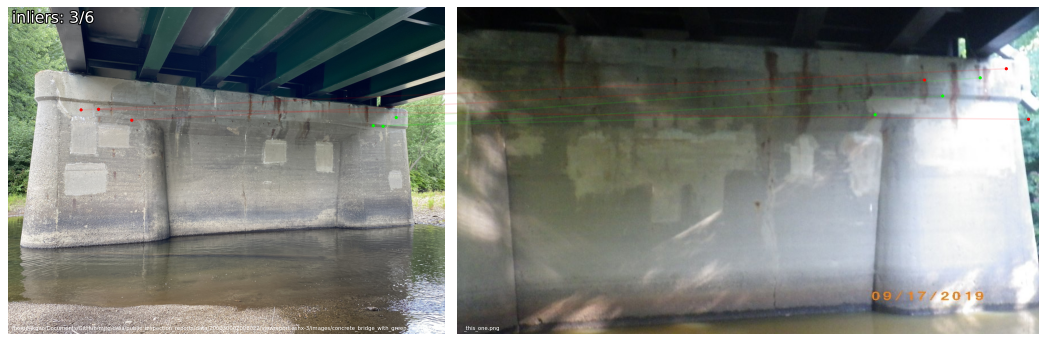

In [19]:
import pycolmap
from packages.hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [model.find_image_with_name(r).image_id for r in references]
conf = {
    "estimation": {"ransac": {"max_error": 12}},
    "refinement": {"refine_focal_length": True, "refine_extra_params": True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches)

print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, model)

We visualize the correspondences between the query images a few mapping images. We can also visualize the estimated camera pose in the 3D map.

In [81]:
pose = pycolmap.Image(cam_from_world=ret["cam_from_world"])
viz_3d.plot_camera_colmap(
    fig, pose, camera, color="rgba(0,255,0,0.5)", name=query, fill=True
)
# visualize 2D-3D correspodences
inl_3d = np.array(
    [model.points3D[pid].xyz for pid in np.array(log["points3D_ids"])[ret["inliers"]]]
)
viz_3d.plot_points(fig, inl_3d, color="lime", ps=1, name=query)
fig.show()